# **Anomaly Detection with AutoEncoders using Tensorflow**

Loading Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
mpl.rcParams['figure.figsize'] = (10, 5)
mpl.rcParams['axes.grid'] = False

In [14]:
!cat "/content/ECG5000_TRAIN.txt" "/content/ECG5000_TEST.txt" > ecg_final.txt
df = pd.read_csv("ecg_final.txt", sep='  ', header=None)
df.shape

<ipython-input-14-6ae3814fc9f5>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv("ecg_final.txt", sep='  ', header=None)


(5000, 141)

In [15]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,1.0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,...,0.160348,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137
1,1.0,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,...,0.560327,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250
2,1.0,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,...,1.284825,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797
3,1.0,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,...,0.491173,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564
4,1.0,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,...,0.966606,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456


Basic Preprocessing

In [16]:
df = df.add_prefix('c')
df['c0'].value_counts()

1.0    2919
2.0    1767
4.0     194
3.0      96
5.0      24
Name: c0, dtype: int64

Train-Test Splitting and Scaling the data

In [17]:
x_train, x_test, y_train, y_test = train_test_split(df.values, df.values[:,0:1], test_size=0.2, random_state=111)

In [18]:
scaler = MinMaxScaler()
data_scaled = scaler.fit(x_train)
train_data_scaled = data_scaled.transform(x_train)
test_data_scaled = data_scaled.transform(x_test)

Separate Anomaly and Normal Data

In [19]:
normal_train_data = pd.DataFrame(train_data_scaled).add_prefix('c').query('c0 == 0').values[:,1:]
anomaly_train_data = pd.DataFrame(train_data_scaled).add_prefix('c').query('c0 > 0').values[:, 1:]
normal_test_data = pd.DataFrame(test_data_scaled).add_prefix('c').query('c0 == 0').values[:,1:]
anomaly_test_data = pd.DataFrame(test_data_scaled).add_prefix('c').query('c0 > 0').values[:, 1:]

Data Visualization

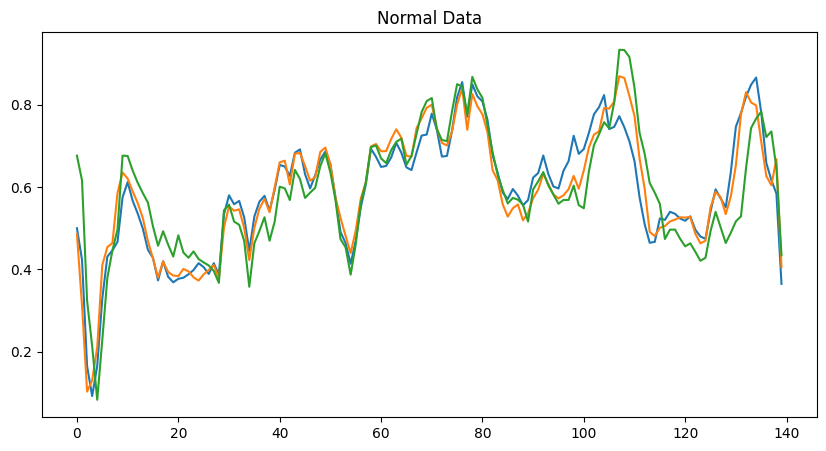

In [20]:
plt.plot(normal_train_data[0])
plt.plot(normal_train_data[1])
plt.plot(normal_train_data[2])
plt.title("Normal Data")
plt.show()

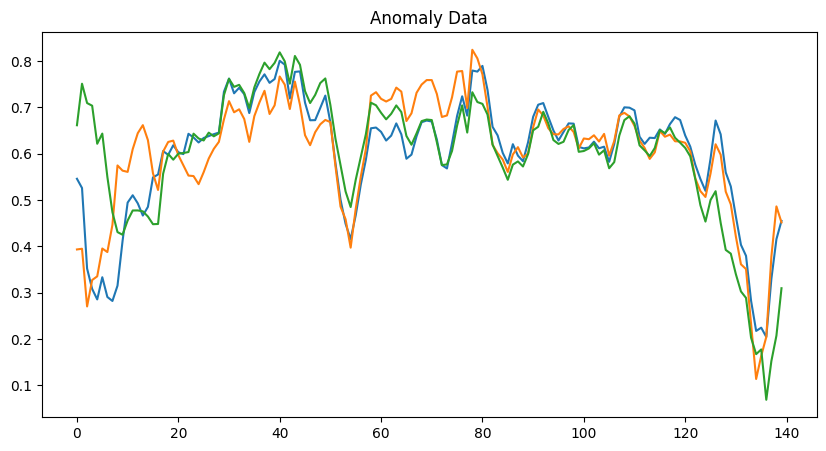

In [21]:
plt.plot(anomaly_train_data[0])
plt.plot(anomaly_train_data[1])
plt.plot(anomaly_train_data[2])
plt.title("Anomaly Data")
plt.show()

Modelling

In [22]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(64, activation="relu"))
model.add(tf.keras.layers.Dense(32, activation="relu"))
model.add(tf.keras.layers.Dense(16, activation="relu"))
model.add(tf.keras.layers.Dense(8, activation="relu"))
model.add(tf.keras.layers.Dense(16, activation="relu"))
model.add(tf.keras.layers.Dense(32, activation="relu"))
model.add(tf.keras.layers.Dense(64, activation="relu"))
model.add(tf.keras.layers.Dense(140, activation="sigmoid"))

In [23]:
class AutoEncoder(Model):
  def __init__(self):
    super(AutoEncoder, self).__init__()
    self.encoder = tf.keras.Sequential([
                  tf.keras.layers.Dense(64, activation="relu"),
                  tf.keras.layers.Dense(32, activation="relu"),
                  tf.keras.layers.Dense(16, activation="relu"),
                  tf.keras.layers.Dense(8, activation="relu")
              ])
    self.decoder = tf.keras.Sequential([
                  tf.keras.layers.Dense(16, activation="relu"),
                  tf.keras.layers.Dense(32, activation="relu"),
                  tf.keras.layers.Dense(64, activation="relu"),
                  tf.keras.layers.Dense(140, activation="sigmoid")
              ])
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


Compile and train the Model

In [24]:
model = AutoEncoder()
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, mode="min")
model.compile(optimizer='adam', loss="mae")
history = model.fit(normal_train_data, normal_train_data, epochs=50, batch_size=120,
                    validation_data=(train_data_scaled[:,1:], train_data_scaled[:, 1:]),
                    shuffle=True,
                    callbacks=[early_stopping]
                    )

Epoch 1/50
20/20 [==============================] - 4s 34ms/step - loss: 0.1227 - val_loss: 0.1035
Epoch 2/50
20/20 [==============================] - 0s 8ms/step - loss: 0.0672 - val_loss: 0.0783
Epoch 3/50
20/20 [==============================] - 0s 8ms/step - loss: 0.0494 - val_loss: 0.0754
Epoch 4/50
20/20 [==============================] - 0s 8ms/step - loss: 0.0478 - val_loss: 0.0746
Epoch 5/50
20/20 [==============================] - 0s 8ms/step - loss: 0.0474 - val_loss: 0.0738
Epoch 6/50
20/20 [==============================] - 0s 8ms/step - loss: 0.0470 - val_loss: 0.0733
Epoch 7/50
20/20 [==============================] - 0s 8ms/step - loss: 0.0469 - val_loss: 0.0730
Epoch 8/50
20/20 [==============================] - 0s 8ms/step - loss: 0.0467 - val_loss: 0.0726
Epoch 9/50
20/20 [==============================] - 0s 8ms/step - loss: 0.0464 - val_loss: 0.0724
Epoch 10/50
20/20 [==============================] - 0s 10ms/step - loss: 0.0457 - val_loss: 0.0711
Epoch 11/50
20/20

Model Evaluation

In [27]:
encoder_out = model.encoder(normal_test_data).numpy() #8 unit representation of data
decoder_out = model.decoder(encoder_out).numpy()

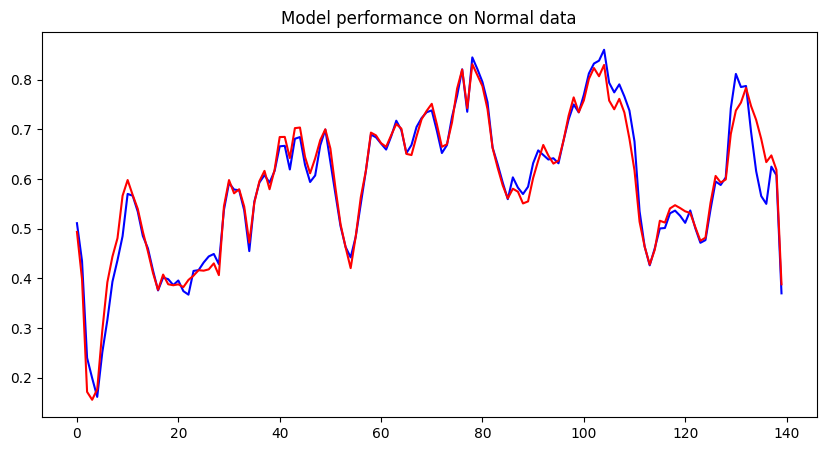

In [26]:
plt.plot(normal_test_data[0], 'b')
plt.plot(decoder_out[0], 'r')
plt.title("Model performance on Normal data")
plt.show()

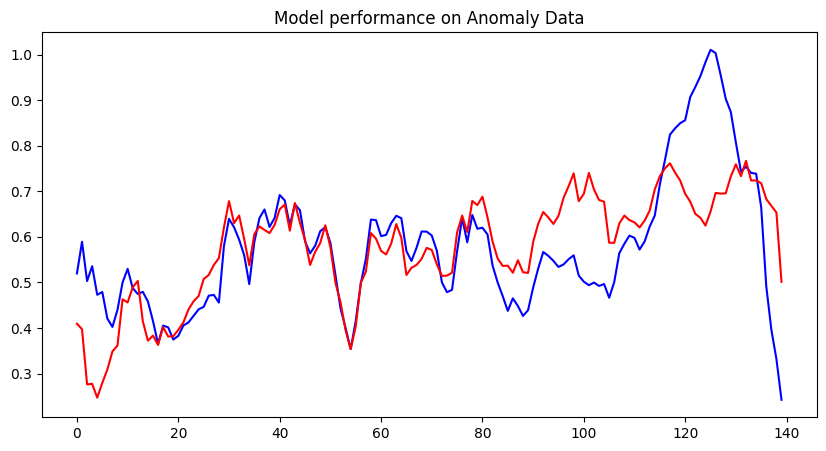

In [28]:
encoder_out_a = model.encoder(anomaly_test_data).numpy() #8 unit representation of data
decoder_out_a = model.decoder(encoder_out_a).numpy()
plt.plot(anomaly_test_data[0], 'b')
plt.plot(decoder_out_a[0], 'r')
plt.title("Model performance on Anomaly Data")
plt.show()


Calculate Loss

18/18 [==============================] - 0s 2ms/step


(array([ 1., 10., 24., 35., 57., 56., 55., 43., 51., 41., 31., 31., 12.,
        12., 13., 13., 11.,  8.,  7., 13.,  4.,  2.,  4.,  6.,  4.,  1.,
         4.,  2.,  1.,  1.,  1.,  0.,  2.,  1.,  0.,  1.,  1.,  0.,  1.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.]),
 array([0.00948714, 0.01111053, 0.01273392, 0.01435731, 0.0159807 ,
        0.01760409, 0.01922748, 0.02085087, 0.02247427, 0.02409766,
        0.02572105, 0.02734444, 0.02896783, 0.03059122, 0.03221461,
        0.033838  , 0.03546139, 0.03708478, 0.03870817, 0.04033156,
        0.04195495, 0.04357835, 0.04520174, 0.04682513, 0.04844852,
        0.05007191, 0.0516953 , 0.05331869, 0.05494208, 0.05656547,
        0.05818886, 0.05981225, 0.06143564, 0.06305903, 0.06468243,
        0.06630582, 0.06792921, 0.0695526 , 0.07117599, 0.07279938,
        0.07442277, 0.07604616, 0.07766955, 0.07929294, 0.08091633,
        0.08253972, 0.08416312, 0.08578651, 0.0874099 , 0.08903329,
        0.09065668]),
 <BarContainer

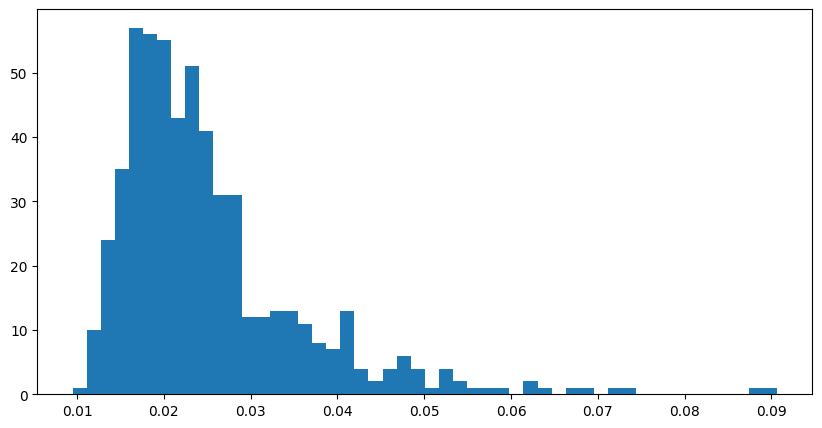

In [29]:
reconstruction = model.predict(normal_test_data)
train_loss = tf.keras.losses.mae(reconstruction, normal_test_data)
plt.hist(train_loss, bins=50)

14/14 [==============================] - 0s 2ms/step


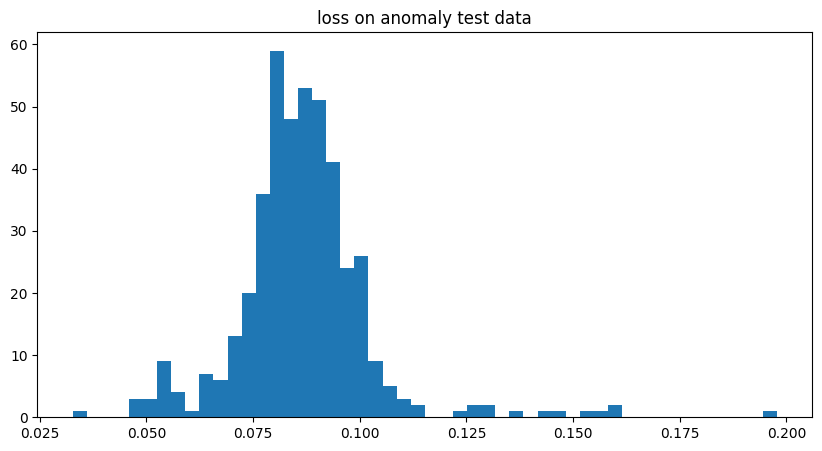

In [30]:
threshold = np.mean(train_loss) + 2*np.std(train_loss)
reconstruction_a = model.predict(anomaly_test_data)
train_loss_a = tf.keras.losses.mae(reconstruction_a, anomaly_test_data)
plt.hist(train_loss_a, bins=50)
plt.title("loss on anomaly test data")
plt.show()

Plot Normal and anomaly Loss together

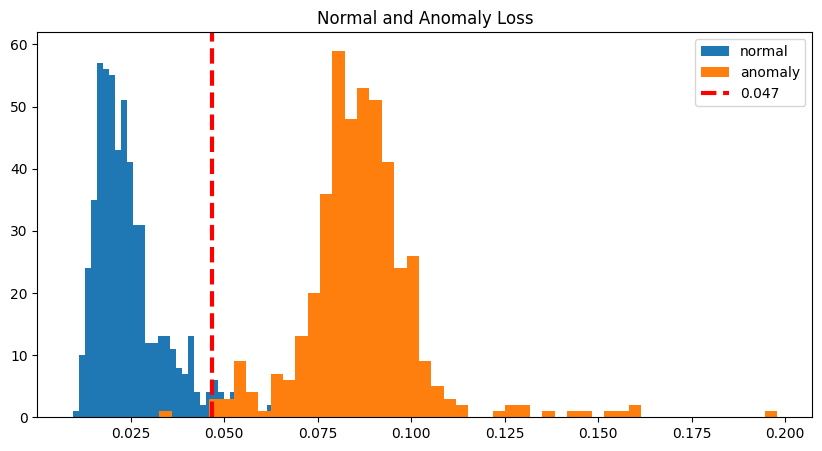

In [31]:
plt.hist(train_loss, bins=50, label='normal')
plt.hist(train_loss_a, bins=50, label='anomaly')
plt.axvline(threshold, color='r', linewidth=3, linestyle='dashed', label='{:0.3f}'.format(threshold))
plt.legend(loc='upper right')
plt.title("Normal and Anomaly Loss")
plt.show()

In [32]:
preds = tf.math.less(train_loss, threshold)
tf.math.count_nonzero(preds)

<tf.Tensor: shape=(), dtype=int64, numpy=534>

In [33]:
preds_a = tf.math.greater(train_loss_a, threshold)
tf.math.count_nonzero(preds_a)

<tf.Tensor: shape=(), dtype=int64, numpy=434>